In [2]:
import os
import torch
import torch.optim as optim
import numpy as np
import roma
from data import generate_cylinder_pts, prepare_point_cloud, normalize_pc, CylinderData
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader

    
train_data = CylinderData(num_poses=5000)
test_data = CylinderData(num_poses=1000)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

pointnet = BarrelNet(k=4, normal_channel=False).cuda()
pointnet.train()


optimizer = optim.Adam(pointnet.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

def compute_loss(sample, radius_pred, axis_pred, use_radius_loss=False, use_axis_loss=True):
    """ Compute loss on the predictions of pointnet """
    assert use_axis_loss or use_radius_loss, "Atleast one of the losses should be used"
    loss_axis = (1 - F.cosine_similarity(sample['axis_vec'], axis_pred, dim=1)).mean()
    loss_radius = F.mse_loss(radius_pred, sample['radius_gt'] / sample['scale_gt'])
    loss = 0.0 
    if use_radius_loss:
        loss = loss + loss_radius
    if use_axis_loss:
        loss = loss + loss_axis
    return loss

def train(model, train_loader, optimizer, scheduler, num_epochs=10000, save_epoch=1000, save_dir='weights/r0'):
    """ 
    """
    os.makedirs(save_dir, exist_ok=True)
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sample in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            radius_pred, axis_pred = model(sample['pts'])
            loss = compute_loss(sample, radius_pred, axis_pred, use_radius_loss=False, use_axis_loss=True)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Step the scheduler at the end of each epoch
        scheduler.step()
        if epoch % 50 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, LR: {scheduler.get_last_lr()[0]}')

        if epoch % save_epoch == 0:
            torch.save(pointnet.state_dict(), os.path.join(save_dir, f'pointnet_iter{epoch}.pth'))

train(pointnet, train_loader, optimizer, scheduler)
torch.save(pointnet.state_dict(), 'weights/pointnet.pth')

# # Example usage

# points = generate_cylinder_pts(1.0, 1.0)
# axis = torch.tensor([0.0, 0.0, 1.0])
# points_valid, radius, burial_offset = prepare_point_cloud(points, axis)
# pts, scale = normalize_pc(points_valid)
# point_cloud_np = points.cpu().numpy()
# point_cloud_rotated_np = points_valid.cpu().numpy()

# fig = plt.figure()
# ax1 = fig.add_subplot(121, projection='3d')
# ax1.scatter(point_cloud_np[:, 0], point_cloud_np[:, 1], point_cloud_np[:, 2], s=1)
# ax1.set_title("Original Point Cloud")

# ax2 = fig.add_subplot(122, projection='3d')
# ax2.scatter(point_cloud_rotated_np[:, 0], point_cloud_rotated_np[:, 1], point_cloud_rotated_np[:, 2], s=1)
# ax2.set_title("Rotated Point Cloud")

ImportError: cannot import name 'generate_cylinder_pts' from 'data' (unknown location)

In [ ]:
from tqdm import tqdm
def test(model, test_loader):
    model.eval()
    running_acc_axis = 0.0
    accs_axis = []
    criterion_cosine = nn.CosineSimilarity(dim=1)
    for sample in tqdm(test_loader):
        with torch.no_grad():
            radius_pred, axis_pred = model(sample['pts'])
            radius_pred = radius_pred * sample['scale_gt'].cuda()
            acc_axis = (1 + criterion_cosine(sample['axis_vec'], axis_pred).mean())/2
            running_acc_axis += acc_axis.item()
            accs_axis.append(acc_axis)
    accs = torch.tensor(accs_axis)
    print(f"Best Accuracy: {torch.max(accs)}")
    print(f"Worst Accuracy: {torch.min(accs)}")
    print(f'Average Accuracy: {running_acc_axis / len(test_loader)}')


test(pointnet, test_loader)


In [1]:
### Creating partially occluded point cloud. 
import mitsuba as mi
import numpy as np 
import roma
import torch
import drjit as dr
from matplotlib import pyplot as plt
import pyrender
import trimesh
import os 

os.environ['PYOPENGL_PLATFORM'] = 'egl'
mi.set_variant('cuda_ad_rgb')

def rotvec_to_matrix(axis, device='cuda'):
    """
    Rotate the point cloud to align its Y-axis with the given axis using PyTorch.
    
    Args:
        axis (torch.Tensor): Target axis to align with, should be of shape (3,).
        device (str): Device to perform the computation ('cpu' or 'cuda').
    Returns:
        torch.Tensor: Rotated point cloud of shape (N, 3).
    """
    ## TODO: make this batched, to rotate the point cloud to different configurations at once. 
    # Normalize the axis
    axis = axis / torch.linalg.norm(axis)
    z_axis = torch.tensor([0., 1., 0.], device='cuda')
    rotation_vector = torch.cross(z_axis, axis)
    angle = torch.arccos(torch.dot(z_axis, axis))
    
    # Convert rotation vector and angle to a PyTorch tensor
    rotation_vector = torch.tensor(rotation_vector, dtype=torch.float32, device=device)
    angle = torch.tensor(angle, dtype=torch.float32, device=device)
    
    # Create the rotation matrix using torch-roma
    rotation_matrix = roma.rotvec_to_rotmat(rotation_vector * angle)
    return rotation_matrix

def get_posed_split_cylinder_mesh(radius, height, axis, burial_offset):
    """Args
    radius (float)
    height (float)
    axis (np.array (3,))
    """
    capped_cylinder = trimesh.creation.cylinder(radius=radius, height=height, sections=64, cap=True)
    capped_cylinder.apply_transform(trimesh.transformations.rotation_matrix(angle=np.pi/2, direction=[1, 0, 0]))
    axis = torch.from_numpy(axis).float().cuda()
    axis = axis / torch.linalg.norm(axis)
    rotmat = rotvec_to_matrix(axis).cpu().numpy()
    pose = np.eye(4)
    pose[:3,:3] = rotmat
    pose[1,3] = burial_offset
    capped_cylinder.apply_transform(pose)
    # Split the mesh based on burial 
    plane_normal = np.array([0., 1., 0.0])
    plane_point = np.array([0., 0., 0.])
    # Perform the split
    sliced_cylinder = capped_cylinder.slice_plane(plane_normal=plane_normal, plane_origin=plane_point)
    return sliced_cylinder 

def get_KRT(fov=np.pi/3, HW=[400,400], cam_origin=[5.0, 0.0, 0.0]):
  """ Compute K matrix and camera pose from mitsuba3 scene. Returns torch.tensor K (3x3), and RT [4x4]"""
  H, W = HW 
  fx = W / (2 * np.tan(fov/2))
  fy = fx
  cx, cy = W/2, H/2
  K = torch.tensor([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]]).float().cuda()
  RT = mi.Transform4f.look_at(origin=cam_origin, target=(1.1*np.array(cam_origin)).tolist(), up=[0.0, 1.0, 0.0]).matrix.numpy()[0]
  RT = RT
  return K, RT

def pyrender_depth(HW, cyl_mesh, fov, cam_origin):
    """ takes a cylinder mesh posed and centered at origin, location of camera, fov, image size
    and returns depth, K, RT """
    mesh = pyrender.Mesh.from_trimesh(cyl_mesh)
    scene = pyrender.Scene()
    scene.add(mesh)
    camera = pyrender.PerspectiveCamera(yfov=fov, aspectRatio=HW[1]/HW[0])
    K, RT = get_KRT(fov, HW, cam_origin)
    
    scene.add(camera, pose=RT)
    light = pyrender.SpotLight(color=np.ones(3), intensity=0.5,
                            innerConeAngle=np.pi/16.0,
                            outerConeAngle=np.pi/6.0)
    scene.add(light, pose=RT)
    r = pyrender.OffscreenRenderer(HW[0], HW[1])
    color, depth = r.render(scene)
    return torch.from_numpy(depth).float().cuda(), K, torch.from_numpy(RT).float().cuda()

def pc_from_depth(depthmap, K, cam2world=torch.eye(4).cuda()):
    """ Compute point cloud in the world frame from depthmap and K matrix 
    Args:
		depthmap (torch.tensor) M,N
		K (torch.tensor) [3,3]
		cam2world (torch.tensor) [4,4] pose matrix that goes from camera to world 
    """
    fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]
    height, width = depthmap.shape[:2]
    v, u = torch.meshgrid(torch.arange(width).cuda(), torch.arange(height).cuda(), indexing='ij')
    u = u.flatten()
    v = v.flatten()
    depth = depthmap.flatten()
    X = (u - cx) * depth / fx 
    Y = -(v - cy) * depth / fy
    Z = depth
    idx = depth > 0
    points = torch.stack([X[idx], Y[idx], -Z[idx]], dim=-1).reshape(-1,3)
    points = points@cam2world[:3,:3].T + cam2world[:3, 3:].T
    return points

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


In [2]:
axis = np.array([0., 0.5, 0.5])
fov = np.pi/3
HW = [400,400]
radius = 1.0 
height = 2.5
cam_origin = [0.0, 0.0,5.0]

    
# cyl_mesh = get_posed_cylinder_mesh(radius, height, axis, -1.5)
cyl_mesh = get_posed_split_cylinder_mesh(radius, height, axis, 0)
depth, K, RT = pyrender_depth(HW, cyl_mesh, fov, cam_origin)
points = pc_from_depth(depth, K, RT)

print(points[:,-1].min())
print(RT)

tensor(-0.1460, device='cuda:0')
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 5.],
        [0., 0., 0., 1.]], device='cuda:0')


/tmp/ipykernel_3928650/3847586291.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotation_vector = torch.tensor(rotation_vector, dtype=torch.float32, device=device)
/tmp/ipykernel_3928650/3847586291.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  angle = torch.tensor(angle, dtype=torch.float32, device=device)


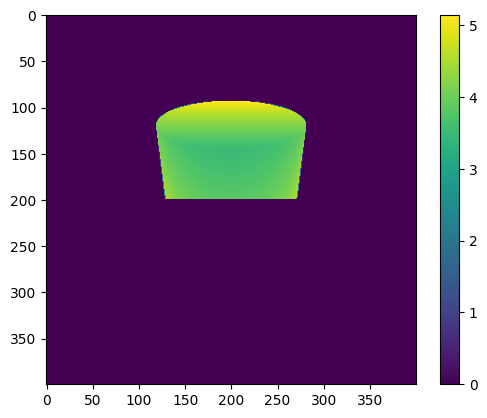

In [3]:
plt.figure()
plt.imshow(depth.cpu().numpy(), cmap=plt.cm.viridis)
plt.colorbar()

In [4]:
import plotly.graph_objects as go
import numpy as np
from barrelnet.pointnet.data import normalize_pc


# Generate some random 3D data points
np.random.seed(0)
points_np =  points.cpu().numpy()
x, y, z = points_np[:,0], points_np[:,1], points_np[:,2]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        color=z,                # Set color to the z values
        colorscale='Viridis',   # Choose a colorscale
        opacity=1.0
    )
)])

# Set the layout
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Point Cloud',
    showlegend=False
)

# Show the plot
fig.show()

In [9]:
normalize_pc(points)[1]

1.5324102640151978

In [155]:
from barrelnet.occo.dgcnn_occo import init_occo 
import pickle as pkl 
import torch 

with open('/home/ubuntu/dust3r/data_real_barrels/rotatedpts-barrel1-1sec-middle.pickle', 'rb') as f:
    df = pkl.load(f)
    
P2z = df['T']
valid = df['isbarrel']
pc = df['p'][valid]
# @P2z[:3,:3].T + P2z[:3,3:].T
occonet = init_occo('/home/ubuntu/dust3r/OcCo/weights/dgcnn_occo_cls.pth')
occonet.eval()

get_model(
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias

In [96]:
# from barrelnet.pointnet.data import normalize_pc

def normalize_pc(valid_pts):
    """
    Normalize the point cloud to feed in to point net. Also estimate the scaling factor. 
    Args:
		valid_pts (torch.tensor) N,C - Point Cloud 
    Returns:
		pts (torch.tensor) N,C normalized Point Cloud 
		scale (float) - value with which to divide the actual radius, for input to network.
    """
    ## Point Cloud Prep for Feeding it to pointnet 
    ## Estimating the scale that needs to be given to the point cloud as input
    pts = valid_pts - valid_pts.mean(dim=0, keepdim=True)
    scale = torch.max(torch.linalg.norm(pts, dim=-1, keepdim=True), dim=0).values.item()
    pts = pts / scale
    return pts, scale 


pc_torch = torch.from_numpy(pc).float()
pc_torch = points 
input, scale = normalize_pc(pc_torch)
idx = torch.randperm(input.shape[0])[:2048]
coarse, fine = occonet(input[idx].permute(1,0).unsqueeze(0).cuda())
print(input.shape)

torch.Size([7810, 3])


In [97]:
import plotly.graph_objects as go
import numpy as np

input_np = input.cpu().numpy()*scale

completed_np = fine.detach().cpu().squeeze().permute(0,1).numpy()*scale

# Create traces for each point cloud
trace1 = go.Scatter3d(
    x=input_np[idx,0],
    y=input_np[idx,1],
    z=input_np[idx,2],
    mode='markers',
    marker=dict(
        size=3,
        color='blue',                # Color of the first point cloud
        opacity=0.8
    ),
    name='Partial Point Cloud'
)

trace2 = go.Scatter3d(
    x=completed_np[:, 0],
    y=completed_np[:, 1],
    z=completed_np[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color='red',                # Color of the second point cloud
        opacity=0.8
    ),
    name='Completed Point Cloud'
)

# Combine the traces into a data list
data = [trace1, trace2]

# Define the layout
layout = go.Layout(
    title='3D Point Clouds',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Show the plot
fig.show()

# # Create a 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=x,
#     y=y,
#     z=z,
#     mode='markers',
#     marker=dict(
#         size=1,
#         color=z,                # Set color to the z values
#         colorscale='Viridis',   # Choose a colorscale
#         opacity=1.0
#     )
# )])

# # Set the layout
# fig.update_layout(
#     scene=dict(
#         xaxis_title='X Axis',
#         yaxis_title='Y Axis',
#         zaxis_title='Z Axis'
#     ),
#     title='3D Point Cloud',
#     showlegend=False
# )

# # Show the plot
# fig.show()

In [107]:
## load cylinder mesh in mitsuba 3 


In [110]:
cyl_cap = get_posed_split_cylinder_mesh(radius, height, axis, -1.5)

/tmp/ipykernel_3906584/819322432.py:33: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_3906584/819322432.py:34: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



ModuleNotFoundError: No module named 'shapely'

In [108]:
capped_cylinder

NameError: name 'capped_cylinder' is not defined